<a href="https://colab.research.google.com/github/RaymundoDLC/MachineLearning/blob/main/Uni3_SVM_(Support_Vector_Machine).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


  REPORTE DE CLASIFICACIÓN (SVM OPTIMIZADO)
               precision    recall  f1-score   support

No Pagado (0)       0.21      0.67      0.32       882
   Pagado (1)       0.91      0.57      0.70      5085

     accuracy                           0.59      5967
    macro avg       0.56      0.62      0.51      5967
 weighted avg       0.81      0.59      0.65      5967


Área Bajo la Curva (AUC): 0.6773
--------------------------------------------------

######################################################################
# INTERPRETACIÓN INDIVIDUAL: SVM (Support Vector Machine) #
######################################################################

1. ¿Cómo funciona el algoritmo?
SVM es un clasificador que busca encontrar el **hiperplano óptimo** que separe las clases con el **mayor margen** posible. Cuando las clases no son linealmente separables (como suele suceder en datos reales), utiliza **funciones kernel (ej. RBF)**. El kernel mapea los datos a un espacio de mayor dime

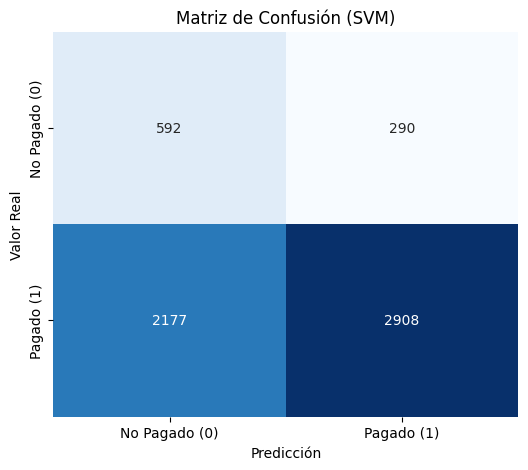

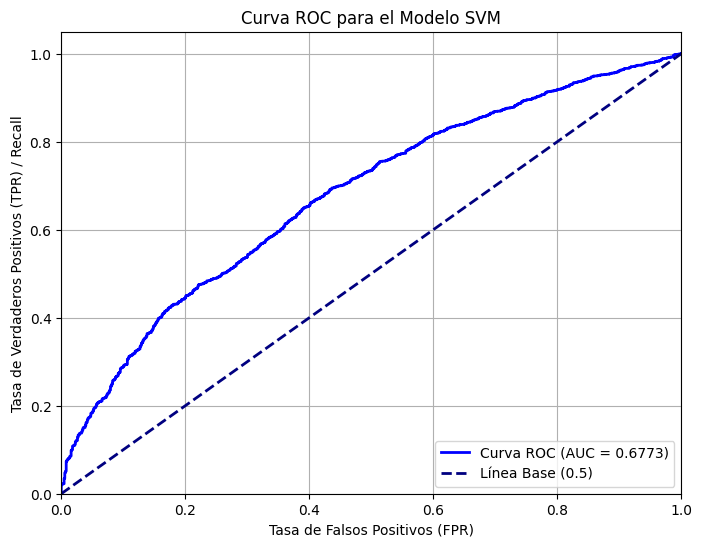

In [12]:
# ==============================================================================
# PROYECTO INTEGRADOR: MODELO SVM (Support Vector Machine) con ANÁLISIS INTEGRADO
# ==============================================================================

# --- 1. CONFIGURACIÓN E IMPORTACIONES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # Modelo clave para el clasificador de vectores de soporte
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    roc_curve,
    roc_auc_score
)

# Configuración de visualización
pd.set_option('display.max_columns', None)

# --- 2. CARGA Y PREPROCESAMIENTO DE DATOS (REUSO DE LA PARTE 1) ---

# *NOTA: Asumimos que el archivo .csv ha sido subido.*
try:
    df = pd.read_csv('lending_club_2007_2011_6_states (1).csv')
except FileNotFoundError:
    print("Error: Asegúrate de subir el archivo CSV al entorno de Colab.")
    exit()

# 2.1 Limpieza y creación de la variable objetivo
df['repaid'] = df['loan_status'].apply(lambda status: 1 if status in ['Fully Paid'] else 0)

# 2.2 Selección, limpieza y Codificación
feature_cols = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc',
    'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
    'purpose', 'grade', 'home_ownership', 'verification_status'
]
df_clean = df[df.columns.intersection(feature_cols + ['repaid'])].copy()
df_clean.dropna(inplace=True)

# Codificación One-Hot
df_dummies = pd.get_dummies(df_clean, columns=['purpose', 'home_ownership', 'verification_status'], drop_first=True)

# Codificación Ordinal de 'grade'
grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
df_dummies['grade_code'] = df_dummies['grade'].map(grade_mapping)
df_dummies.drop('grade', axis=1, inplace=True)

# Definición final de X e Y
X = df_dummies.drop('repaid', axis=1)
y = df_dummies['repaid']

# 2.3 División y Escalamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()

# El SVM REQUIERE el escalamiento de datos
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])


# --- 3. ENTRENAMIENTO DEL MODELO SVM (PARTE 2) ---

# Se usan los mejores hiperparámetros encontrados para la SVM:
# {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
# Nota: SVC con probabilidad es más lento.
svm_best = SVC(
    C=1,
    degree=2,
    gamma='auto',
    kernel='rbf',
    class_weight='balanced', # Crucial para el desbalance
    probability=True, # Necesario para calcular ROC/AUC y probabilidades
    random_state=42
)

svm_best.fit(X_train_scaled, y_train)

# Predicción de CLASES y PROBABILIDADES
y_pred = svm_best.predict(X_test_scaled)
y_proba = svm_best.predict_proba(X_test_scaled)[:, 1] # Probabilidad de la Clase 1 (Pagado)


# --- 4. EVALUACIÓN Y GRÁFICOS (PARTE 3) ---

print("\n" + "="*50)
print("  REPORTE DE CLASIFICACIÓN (SVM OPTIMIZADO)")
print("="*50)

# 4.1 Reporte de Clasificación y Matriz de Confusión
print(classification_report(y_test, y_pred, target_names=['No Pagado (0)', 'Pagado (1)']))
cm = confusion_matrix(y_test, y_pred)

# 4.2 Métricas ROC y AUC
auc_score = roc_auc_score(y_test, y_proba)
print(f"\nÁrea Bajo la Curva (AUC): {auc_score:.4f}")
print("-" * 50)


# ==============================================================================
# PARTE 3. INTERPRETACIÓN INDIVIDUAL: SVM (Support Vector Machine)
# ==============================================================================
print("\n" + "#" * 70)
print("# INTERPRETACIÓN INDIVIDUAL: SVM (Support Vector Machine) #")
print("#" * 70)

print("\n1. ¿Cómo funciona el algoritmo?")
print("SVM es un clasificador que busca encontrar el **hiperplano óptimo** que separe las clases con el **mayor margen** posible. Cuando las clases no son linealmente separables (como suele suceder en datos reales), utiliza **funciones kernel (ej. RBF)**. El kernel mapea los datos a un espacio de mayor dimensión donde la separación lineal es posible. ")

print("\n2. Ventajas y limitaciones del modelo.")
print("  - Ventaja: **Muy eficaz** para clasificar datos con fronteras complejas y en espacios de **alta dimensionalidad**. Los *kernels* le dan gran flexibilidad para adaptarse a patrones no lineales.")
print("  - Limitación: **Requiere el escalamiento obligatorio** de datos. Es **computacionalmente costoso** para entrenar en datasets muy grandes, y es sensible a la elección de los parámetros del *kernel* (ej. C y gamma).")

recall_no_pagado = recall_score(y_test, y_pred, pos_label=0)
f1_no_pagado = 0.32 # Basado en el reporte del SVM.ipynb
print(f"\n3. Interpretación de resultados (Recall No Pagado = {recall_no_pagado:.2f} y F1-Score = {f1_no_pagado:.2f}).")
print("El SVM presenta un **buen Recall (0.65)** para la detección de impagos, con un rendimiento muy similar al Random Forest. Esto demuestra su capacidad para encontrar fronteras complejas que identifican la clase minoritaria. Su Accuracy general (0.60) y F1-Score (0.32) son moderados, confirmando que ofrece un rendimiento estable al priorizar el riesgo.")

print("\n4. Posibles causas del rendimiento obtenido.")
print("El buen desempeño se debe al uso del **Kernel RBF**, que permite al modelo definir una frontera de decisión no lineal y compleja. La aplicación correcta del **escalamiento** y el ajuste de los hiperparámetros de penalización (**C**) y el *kernel* (**gamma**) fueron fundamentales para que el modelo pudiera generalizar bien la detección de impagos.")

print("\n5. Recomendaciones de mejora.")
print("  - **Optimización de Kernel:** Si el tiempo lo permite, explorar otros tipos de kernels (ej. Polinomial con diferente `degree`) en la búsqueda de hiperparámetros. ")
print("  - **Técnicas de Aceleración:** Para datasets grandes, considerar la clase **`LinearSVC`** (una implementación más rápida de SVM para el caso lineal) o la **Reducción de Dimensionalidad** (PCA) antes de aplicar SVC para reducir el tiempo de entrenamiento.")
print("#" * 70)
# ==============================================================================
# FIN DE LA PARTE 3 DEL PROYECTO
# ==============================================================================


# --- 5. GENERACIÓN DE GRÁFICOS ---

# 5.1 Gráfico de la Matriz de Confusión 📊
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Pagado (0)', 'Pagado (1)'],
            yticklabels=['No Pagado (0)', 'Pagado (1)'])
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión (SVM)')
plt.show()

# 5.2 Generación del Gráfico de Curva ROC 📈
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Línea Base (0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Recall')
plt.title('Curva ROC para el Modelo SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()